In [0]:
import os
import requests
from urllib.parse import urljoin

try:
  import goodtables
except:
  !pip install goodtables
  import goodtables
try:
  import tableschema
except:
  !pip install tableschema
  import tableschema
try:
  import tableschema_pandas
except:
  !pip install tableschema_pandas
  import tableschema_pandas
try:
  import graphviz
except:
  !pip install graphviz
  !apt-get install graphviz
  import graphviz
from tableschema import Schema
#!apt-get install graphviz

try:
  import statsmodels
except:
  !pip install statsmodels
  import statsmodels


Clean your JSON with https://jsonlint.com/
Check against schemas with https://try.goodtables.io/

In [0]:
GITHUB_USER  = "e-lo"
GITHUB_REPO  = "forecast-cards"
BRANCH       = "master"
SHA          = "f35185168b238429157adcbf5ba09d09ae7d0172"
SUBDIRS      = ["examples"] #specify at least one
repo_api = "".join(["https://api.github.com/repos/",GITHUB_USER,"/",GITHUB_REPO,"/git/trees/",SHA,"?recursive=1"])
repo_raw = "".join(["https://raw.github.com/",GITHUB_USER,"/",GITHUB_REPO,"/",BRANCH,"/"])

## Find and validate **schema**s

In [35]:
## specify which schemas to use
schemas_loc = {
    "poi": urljoin(repo_raw,"poi-schema.json"),
    "scenario": urljoin(repo_raw,"scenario-schema.json"),
    "project": urljoin(repo_raw,"project-schema.json"),
    "observations": urljoin(repo_raw,"observations-schema.json"),
    "forecast": urljoin(repo_raw,"forecast-schema.json"),
}

## Confirm Schemas are valid
schemas = {}
for k,v in schemas_loc.items():
  print ("Obtaining ", k,"schema from: ",v)
  schemas[k] = Schema(v)
#requests.get(v)
#print(schemas['poi'])

Obtaining  poi schema from:  https://raw.github.com/e-lo/forecast-cards/master/poi-schema.json
Obtaining  scenario schema from:  https://raw.github.com/e-lo/forecast-cards/master/scenario-schema.json
Obtaining  project schema from:  https://raw.github.com/e-lo/forecast-cards/master/project-schema.json
Obtaining  observations schema from:  https://raw.github.com/e-lo/forecast-cards/master/observations-schema.json
Obtaining  forecast schema from:  https://raw.github.com/e-lo/forecast-cards/master/forecast-schema.json


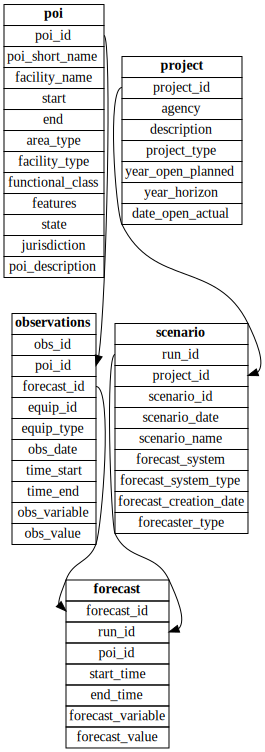

In [36]:
#table = tableschema.Table(os.path.join(EX,'poi-rx123.csv'), schema=os.path.join(GH,"poi-schema.json"))
#[i['name'] for i in schemas["poi"].descriptor['fields']]
from graphviz import Digraph
erd_graph = Digraph(name='Schemas', node_attr={'shape': 'plain'})


for k,v in schemas.items():
  node_label="<<table border='0' cellborder='1' cellspacing='0'>"
  node_label+="<tr><td><b>"
  node_label+=str(k)
  node_label+="</b></td></tr>"
  for f in v.descriptor['fields']:
    node_label+="<tr><td port='"
    node_label+=f['name']
    node_label+="'>"
    node_label+=f['name']
    node_label+="</td></tr>"
  node_label+="</table>>"
  erd_graph.node(k,label = node_label)

erd_graph.edge("poi:poi_id", "observations:poi_id")
erd_graph.edge("observations:forecast_id","forecast:forecast_id")
erd_graph.edge("scenario:run_id","forecast:run_id")
erd_graph.edge("project:project_id","scenario:project_id")

erd_graph 
  

## Locate Data

In [0]:
r = requests.get(repo_api)
rj = r.json()

In [38]:
card_locs = {
           "poi": [],
           "scenario": [],
           "project": [],
           "observations": [],
           "forecast": [],
    }

## todo better regex matching by project
for file in rj['tree']:
  path_list = file['path'].split("/")
  
  if len(path_list)>2 and path_list[0] in SUBDIRS and file['type']=='blob':
      if path_list[-1][0:8].lower()=="forecast":
          full_url = urljoin(repo_raw,file['path'])
          print("adding",full_url,"to forecast")
          card_locs["forecast"].append(full_url)
      if path_list[-1][0:12].lower()=="observations":
          full_url = urljoin(repo_raw,file['path'])
          print("adding",full_url,"to observations")
          card_locs["observations"].append(full_url)
      if path_list[-1][0:3].lower()=="poi":
          full_url = urljoin(repo_raw,file['path'])
          print("adding",full_url,"to poi")
          card_locs["poi"].append(full_url)          
      if path_list[-1][0:7].lower()=="project":
          full_url = urljoin(repo_raw,file['path'])
          print("adding",full_url,"to project")
          card_locs["project"].append(full_url)     
      if path_list[-1][0:8].lower()=="scenario":
          full_url = urljoin(repo_raw,file['path'])
          print("adding",full_url,"to scenario")
          card_locs["scenario"].append(full_url)   
                    
#card_locs


adding https://raw.github.com/e-lo/forecast-cards/master/examples/emeraldcitydot-rx123-yellowbrickroadhov/forecasts/forecast-A1-1960-1940-F1.csv to forecast
adding https://raw.github.com/e-lo/forecast-cards/master/examples/emeraldcitydot-rx123-yellowbrickroadhov/observations/observations-1935.csv to observations
adding https://raw.github.com/e-lo/forecast-cards/master/examples/emeraldcitydot-rx123-yellowbrickroadhov/observations/observations-1960.csv to observations
adding https://raw.github.com/e-lo/forecast-cards/master/examples/emeraldcitydot-rx123-yellowbrickroadhov/poi-rx123.csv to poi
adding https://raw.github.com/e-lo/forecast-cards/master/examples/emeraldcitydot-rx123-yellowbrickroadhov/project-rx123.csv to project
adding https://raw.github.com/e-lo/forecast-cards/master/examples/emeraldcitydot-rx123-yellowbrickroadhov/scenarios-rx123.csv to scenario


## Validate Data Tables

If errors found, try https://try.goodtables.io as a good GUI for identifying issues.

In [39]:
from goodtables import validate
reports={}
for k,v in card_locs.items():
  #print ("validating",k,v)
  reports[k] = validate(card_locs[k][0],schema=requests.get(schemas_loc[k]).json())
  if not reports[k]['valid']: 
    print ("--->INVALID TABLE", k)
    reports[k]
  else:
    print ("--->VALID",k)

--->VALID poi
--->INVALID TABLE scenario
--->VALID project
--->VALID observations
--->VALID forecast


In [40]:
reports['scenario']

{'error-count': 2,
 'preset': 'table',
 'table-count': 1,
 'tables': [{'encoding': 'utf-8',
   'error-count': 2,
   'errors': [{'code': 'unique-constraint',
     'column-number': 2,
     'message': 'Rows 2, 3 has unique constraint violation in column 2',
     'message-data': {'row_numbers': '2, 3'},
     'row-number': 3},
    {'code': 'unique-constraint',
     'column-number': 2,
     'message': 'Rows 2, 3, 4 has unique constraint violation in column 2',
     'message-data': {'row_numbers': '2, 3, 4'},
     'row-number': 4}],
   'format': 'csv',
   'headers': ['run_id',
    'project_id',
    'scenario_id',
    'scenario_date',
    'scenario_name',
    'forecast_system',
    'forecast_system_type',
    'forecast_creation_date',
    'forecaster_type'],
   'row-count': 4,
   'schema': 'table-schema',
   'scheme': 'https',
   'source': 'https://raw.github.com/e-lo/forecast-cards/master/examples/emeraldcitydot-rx123-yellowbrickroadhov/scenarios-rx123.csv',
   'time': 0.303,
   'valid': Fals

## Read data into Pandas Storage

## Create Estimation File
- ProjectID	
- SegmentID	
- CountID
- InternalProjectID	
- CounterID	
- Station_Identifier	
- BriefDescription	
- ProjectYear	
- ImprovementType	
- AreaType
- FuncClass	
- State	
- TollType	
- TrafficForecast	
- ForecastYear	
- ForecastYearType	
- YearForecastProduced	
- ForecastingAgency	
- ForecastMethodology	
- SegmentDescription	
- Year_ofObservation	
- FunctionalClass
- Count	



In [0]:
import pandas as pd
project_df = pd.concat([pd.read_csv(f, parse_dates=['year_open_planned','year_horizon','date_open_actual'],infer_datetime_format=True) for f in card_locs["project"]], ignore_index=True)
scenario_df = pd.concat([pd.read_csv(f, parse_dates=['forecast_creation_date','scenario_date'],infer_datetime_format=True) for f in card_locs["scenario"]], ignore_index=True)
scenario_proj_df = scenario_df.merge(project_df, on='project_id', how='left')

poi_df = pd.concat([pd.read_csv(f) for f in card_locs["poi"]], ignore_index=True)
observations_df = pd.concat([pd.read_csv(f, dtype={'obs_value':float}) for f in card_locs["observations"]], ignore_index=True)
observations_poi_df = observations_df.merge(poi_df, on='poi_id', how='left')

forecast_df = pd.concat([pd.read_csv(f, dtype={'forecast_value':float}) for f in card_locs["forecast"]], ignore_index=True)

all_df = forecast_df.merge(observations_poi_df, on='forecast_match_id', how='left').merge(scenario_proj_df, on='run_id', how='left')


In [121]:
all_df.dtypes

forecast_id_x                     object
run_id                            object
poi_id_x                          object
forecast_match_id                 object
start_time                        object
end_time                          object
forecast_variable                 object
forecast_value                   float64
equip_id                          object
equip_type                        object
forecast_id_y                    float64
obs_date                          object
obs_id                            object
obs_value                        float64
obs_variable                      object
poi_id_y                          object
time_end                          object
time_start                        object
poi_short_name                    object
facility_name                     object
start                             object
end                               object
area_type                         object
facility_type                     object
functional_class

## Clean data and create estimation file

In [122]:
# Only keep records that have all required variables
REQUIRED_VARS = ['scenario_date','forecast_system_type','forecast_creation_date','forecast_value','forecast_value','obs_value', 'area_type', 'facility_type','state','project_type']
usable_df= all_df.dropna(subset=REQUIRED_VARS)
print("Kept",len(usable_df),"of",len(all_df))


Kept 8 of 8


In [123]:
usable_df

,forecast_id_x,run_id,poi_id_x,forecast_match_id,start_time,end_time,forecast_variable,forecast_value,equip_id,equip_type,...,forecast_system,forecast_system_type,forecast_creation_date,forecaster_type,agency,description,project_type,year_open_planned,year_horizon,date_open_actual
0,f1,r2,ybr-1-ib,f1,8:00:00,9:00:00,volume,456.0,e1,tube,...,the great OZ machine v1.2,pop-growth-rates,1937-03-03,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT
1,f2,r2,ybr-1-ib,f2,9:00:00,10:00:00,volume,456.0,e1,tube,...,the great OZ machine v1.2,pop-growth-rates,1937-03-03,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT
2,f3,r2,ybr-2-ib,f3,8:00:00,9:00:00,volume,500.0,e2,tube,...,the great OZ machine v1.2,pop-growth-rates,1937-03-03,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT
3,f4,r2,ybr-2-ib,f4,9:00:00,9:00:00,volume,512.0,e2,tube,...,the great OZ machine v1.2,pop-growth-rates,1937-03-03,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT
4,f5,r3,ybr-1-ib,f1,8:00:00,9:00:00,volume,500.0,e1,tube,...,the great OZ machine v1.5,travel-model,1940-02-02,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT
5,f6,r3,ybr-1-ib,f2,9:00:00,10:00:00,volume,602.0,e1,tube,...,the great OZ machine v1.5,travel-model,1940-02-02,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT
6,f7,r3,ybr-2-ib,f3,8:00:00,9:00:00,volume,448.0,e2,tube,...,the great OZ machine v1.5,travel-model,1940-02-02,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT
7,f8,r3,ybr-2-ib,f4,9:00:00,9:00:00,volume,510.0,e2,tube,...,the great OZ machine v1.5,travel-model,1940-02-02,consultant,Emerald City DOT,adding an HOV2 lane from Munchkin Land to the ...,hov,1939-01-01,1959-01-01,NaT


In [0]:
AdjustedForecast_over30k
       + Scale_UnemploymentRate_YearProduced
       + Scale_DiffYear
       + Scale_IT_NewRoad
       + Scale_FM_TravelModel
       + Scale_FC_Arterial
       + Scale_FC_CollectorLocal
        df["Scale_UnemploymentRate_OpeningYear"] = df["UnemploymentRate_OpeningYear"] * df["AdjustedForecast"]

In [0]:
## create each of the decades
usable_df['creation_decade'] = (usable_df['forecast_creation_date'].apply(lambda x: x.year//10*10)).astype('category')
usable_df['scenario_decade'] = (usable_df['scenario_date'].apply(lambda x: x.year//10*10)).astype('category')

## create large projects dummy
breakpoint = 30000
bins = [usable_df['forecast_value'].min(), breakpoint, breakpoint+usable_df['forecast_value'].max()]
labels = ["small_project","large_project"]
usable_df['project_size'] = pd.cut(usable_df['forecast_value'], bins=bins, labels=labels)
#usable_df

In [186]:
## Create dummy variables 
categorical_cols = ['project_size','creation_decade','scenario_decade','functional_class','forecast_system_type','project_type','agency','forecaster_type','area_type','facility_type','state']
dummy_df = pd.get_dummies(usable_df[categorical_cols])
usable_dummy_df = pd.concat([usable_df[[v for v in REQUIRED_VARS if v not in categorical_cols]],dummy_df],axis=1)
usable_dummy_df.columns


Index(['scenario_date', 'forecast_creation_date', 'forecast_value',
       'forecast_value', 'obs_value', 'project_size_small_project',
       'project_size_large_project', 'creation_decade_1930',
       'creation_decade_1940', 'scenario_decade_1960',
       'functional_class_ Minor Arterial', 'functional_class_Minor Arterial',
       'forecast_system_type_pop-growth-rates',
       'forecast_system_type_travel-model', 'project_type_hov',
       'agency_Emerald City DOT', 'forecaster_type_consultant',
       'area_type_ rural', 'facility_type_ road', 'state_ OZ'],
      dtype='object')

In [177]:
#usable_dummy_df 
##TODO, not currently working
scaled_df = usable_dummy_df.mul(usable_dummy_df['forecast_value'], axis=0)
#scaled_df 


,agency_Emerald City DOT,area_type_ rural,creation_decade_1930,creation_decade_1940,facility_type_ road,forecast_creation_date,forecast_system_type_pop-growth-rates,forecast_system_type_travel-model,forecast_value,forecast_value,forecast_value,forecast_value,forecaster_type_consultant,functional_class_ Minor Arterial,functional_class_Minor Arterial,obs_value,project_type_hov,scenario_date,scenario_decade_1960,state_ OZ
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207936.0,207936.0,207936.0,207936.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207936.0,207936.0,207936.0,207936.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250000.0,250000.0,250000.0,250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262144.0,262144.0,262144.0,262144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250000.0,250000.0,250000.0,250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362404.0,362404.0,362404.0,362404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200704.0,200704.0,200704.0,200704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260100.0,260100.0,260100.0,260100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Estimate Quantiles

With understanding that GDE noted that this package doesn't work right...

In [125]:
import statsmodels.formula.api as smf
mod = smf.quantreg('obs_value ~ forecast_value', usable_df)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              obs_value   Pseudo R-squared:                 -inf
Model:                       QuantReg   Bandwidth:                       0.000
Method:                 Least Squares   Sparsity:                          nan
Date:                Thu, 15 Nov 2018   No. Observations:                    8
Time:                        23:40:24   Df Residuals:                        6
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        600.0000        nan        nan        nan         nan         nan
forecast_value -1.157e-11        nan        nan        nan         nan         nan

The condition number is large, 5.4e+03. This might indicate that there are
strong multicollinearity or other numer

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:204: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum(e) / np.sum(ered)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/py

In [126]:
lm = smf.ols('obs_value ~ forecast_value', data=usable_df).fit()

print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              obs_value   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -6.000
Date:                Thu, 15 Nov 2018   Prob (F-statistic):               1.00
Time:                        23:40:31   Log-Likelihood:                 221.55
No. Observations:                   8   AIC:                            -439.1
Df Residuals:                       6   BIC:                            -438.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        600.0000      1e-12   5.99e

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [109]:
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              obs_value   Pseudo R-squared:                 -inf
Model:                       QuantReg   Bandwidth:                       0.000
Method:                 Least Squares   Sparsity:                          nan
Date:                Thu, 15 Nov 2018   No. Observations:                    8
Time:                        23:18:09   Df Residuals:                        6
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        600.0000        nan        nan        nan         nan         nan
forecast_value -1.157e-11        nan        nan        nan         nan         nan

The condition number is large, 5.4e+03. This might indicate that there are
strong multicollinearity or other numer

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum(e) / np.sum(ered)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [158]:
1081 // 10*10


1080

In [137]:
1081//10*10


1080

In [138]:
1080//10

108